<a href="https://colab.research.google.com/github/dany-kuznetsov/topic_model_lda_hyper_params_opt/blob/master/guided_lda_hyperopt_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook with an example of implementation Guided LDA model

## Download modules in google collab

In [1]:
! pip install hyperopt==0.2.5

     |████████████████████████████████| 972kB 15.8MB/s 
  Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2


In [2]:
!pip install git+https://github.com/CatalinVoss/GuidedLDA

  Cloning https://github.com/CatalinVoss/GuidedLDA to /tmp/pip-req-build-rcmxmu4m
  Running command git clone -q https://github.com/CatalinVoss/GuidedLDA /tmp/pip-req-build-rcmxmu4m
  Created wheel for guidedlda: filename=guidedlda-2.0.0.dev27-cp37-cp37m-linux_x86_64.whl size=2492627 sha256=d39710b0af0e53bcb32dd53e9257115b4303e8ba5594ba5b0aa3089f1ef5ac7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-5axyfy2f/wheels/a4/d5/1c/a4bf220c10fc39992c8af75ee87dc0cdd2c332bf6923b4c5eb
Successfully built guidedlda


## Ordinary imports

In [3]:
import numpy as np
import pandas as pd
import math
import csv

from datetime import datetime

import os.path
from os import path
import time

import matplotlib.pyplot as plt
import seaborn as sns

import re
import scipy
import nltk
import gensim
import guidedlda
import spacy

from functools import partial

In [4]:
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
import pickle
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from sklearn.feature_extraction import text

## Imports of custom functions for two step hyper param optimization

In [7]:
import topic_model_hyper_param_opt

In [8]:
random_seed=420

# General pipeline GuidedLDA

In [9]:
# Read the dataset
texts_df = pd.read_csv('texts_10kGNAD.csv')
texts_df['text'] = texts_df['text'].astype(str)
print(texts_df.shape)
texts_df.tail(2)

(10273, 3)


,Unnamed: 0,label,text
10271,10271,Wissenschaft,Klimatische Verschlechterungen dürften zur Auf...
10272,10272,Wissenschaft,Knochen können zum Verständnis des Lebens in d...


In [10]:
custom_stop_words = [
    'nan', 'ja', 'nein', 'nr', 'nee',
    'fuer', 'ueber', 'mehr', 'ab', 'beim', 
    'wurde', 'worden', 'wurden', 'wuerde', 'waere', 
    'bereits',
]

In [11]:
from topic_model_hyper_param_opt import preprocess_doc
# Preprocess texts.
texts_df['text_preprocessed'] = texts_df['text'].apply(
    lambda x: preprocess_doc(x, lang='german', sw=True, custom_stop_words=custom_stop_words)
)

In [12]:
from topic_model_hyper_param_opt import create_document_term_matrix_from_texts_series
# Create document term matrix.
data_vect, vectorizer, data_dtm  = create_document_term_matrix_from_texts_series(
    texts_df['text_preprocessed'],
    ngram_range=(1, 1),
    index_for_dtm=texts_df.index,
    vocabulary_cut_offs={
        'min_df': 0.002, # 0.0
        'max_df': 0.999 # 1.0
    }
)

# Create dictionary and corpus to get coherence score later.
dictionary = gensim.corpora.dictionary.Dictionary(
    documents=texts_df['text_preprocessed'], 
    prune_at=200000000
)
corpus = [dictionary.doc2bow(text) for text in texts_df['text_preprocessed']]

feature_names = vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(feature_names))

data_dtm.tail(2)

,abbau,abbauen,abbruch,abc,abd,abdecken,abdullah,abend,abends,abenteuer,abermals,abfahrt,abgabe,abgaben,abgang,abgebaut,abgeben,abgebildet,abgebrochen,abgedeckt,abgegeben,abgehalten,abgelaufen,abgelaufenen,abgelegt,abgelehnt,abgeloest,abgenommen,abgeordnete,abgeordneten,abgeordneter,abgerufen,abgesagt,abgeschafft,abgeschlagen,abgeschlossen,abgeschlossenen,abgeschnitten,abgeschoben,abgesegnet,...,zuversichtlich,zuvor,zuwachs,zuwaechse,zuwanderer,zuwanderung,zuzug,zuzulassen,zwang,zwangslaeufig,zwanzig,zweck,zwecke,zwecks,zwei,zweieinhalb,zweier,zweifel,zweifellos,zweifeln,zweimal,zweitaegigen,zweite,zweiten,zweitens,zweiter,zweites,zweitgroesste,zweitgroessten,zweitligisten,zwingen,zwingend,zwingt,zwischendurch,zwischenfaelle,zwischenfall,zwischenzeit,zwoelf,zwoelften,zypern
10271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Define topics seed to guide LDA model
seed_topic_list_10kGNAD = [
    ['telekom'],
    ['saison', 'spiel', 'team'],
    ["google", "android", "nutzer", "unternehmen",  "smartphone", "app", 'hersteller'],
    ['tv', 'radio', 'sendung'],
    ['iphone', 'apple', 'ipad'],
    ['praesident', 'wahl'],
    ['fluechtlinge'],
    ['syrien', 'tuerkei', 'getoetet'],
    ['yahoo'],
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list_10kGNAD):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [14]:
from topic_model_hyper_param_opt import stage_1_optimization_guidedlda
from topic_model_hyper_param_opt import trails_of_hyper_opt_to_dataframe_guidedlda

# Find almost all optimal params of LDA model with fixed number of topics.
params_optimal_stage_1, trials_stage_1 = stage_1_optimization_guidedlda(
    data_vect=data_vect,
    seed_topics=seed_topics,
    dictionary=dictionary,
    feature_names=feature_names,
    corpus=corpus,
    param_dict={},
    metric_to_optimize='coherence_consistent',
    stage_1_params={
        'n_topics_min': 8,
        'n_topics_max': 16,
        'n_iter_param': 100,
        'refresh_param': 20,
        'seed_confidence': 0.15,
        'max_eval_param': 10,
        'timeout_param': 86400, 
    },
    random_seed=random_seed
)

print(params_optimal_stage_1)

trials_stage_1_df = trails_of_hyper_opt_to_dataframe_guidedlda(trials_stage_1)
trials_stage_1_df.to_csv('trials_stage_1_df_guidedlda.csv')

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 14

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17873260

INFO:guidedlda:<20> log likelihood: -13636695

INFO:guidedlda:<40> log likelihood: -13365991

INFO:guidedlda:<60> log likelihood: -13265797

INFO:guidedlda:<80> log likelihood: -13214670

INFO:guidedlda:<99> log likelihood: -13178717

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 5000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accu

 10%|█         | 1/10 [00:32<04:55, 32.81s/trial, best loss: 1.7869203760982117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005917 seconds

INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.786920

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 9

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17328185

INFO:guidedlda:<20> log likelihood: -13862123

INFO:guidedlda:<40> log likelihood: -13634349

INFO:guidedlda:<60> log likelihood: -13548942

INFO:guidedlda:<80> log likelihood: -13505784

INFO:guidedlda:<99> log likelihood: -13472808

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_an

 20%|██        | 2/10 [01:03<04:16, 32.08s/trial, best loss: 1.7244443311999804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003343 seconds

INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.724444

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 11

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17305081

INFO:guidedlda:<20> log likelihood: -13649562

INFO:guidedlda:<40> log likelihood: -13424796

INFO:guidedlda:<60> log likelihood: -13342379

INFO:guidedlda:<80> log likelihood: -13302093

INFO:guidedlda:<99> log likelihood: -13273070

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 30%|███       | 3/10 [01:34<03:43, 31.98s/trial, best loss: 1.7244443311999804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002932 seconds

INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.724444

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 11

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17736300

INFO:guidedlda:<20> log likelihood: -13805958

INFO:guidedlda:<40> log likelihood: -13528041

INFO:guidedlda:<60> log likelihood: -13397491

INFO:guidedlda:<80> log likelihood: -13323112

INFO:guidedlda:<99> log likelihood: -13274105

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 40%|████      | 4/10 [02:05<03:09, 31.63s/trial, best loss: 1.662369690645506] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005500 seconds

INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.662370

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 11

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17752097

INFO:guidedlda:<20> log likelihood: -13778697

INFO:guidedlda:<40> log likelihood: -13549202

INFO:guidedlda:<60> log likelihood: -13478319

INFO:guidedlda:<80> log likelihood: -13438661

INFO:guidedlda:<99> log likelihood: -13414561

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 50%|█████     | 5/10 [02:37<02:38, 31.64s/trial, best loss: 1.662369690645506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003202 seconds

INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.662370

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 14

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17813061

INFO:guidedlda:<20> log likelihood: -13434644

INFO:guidedlda:<40> log likelihood: -13138340

INFO:guidedlda:<60> log likelihood: -13044695

INFO:guidedlda:<80> log likelihood: -13007151

INFO:guidedlda:<99> log likelihood: -12990113

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 60%|██████    | 6/10 [03:09<02:07, 31.82s/trial, best loss: 1.662369690645506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002885 seconds

INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.662370

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 10

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -16998868

INFO:guidedlda:<20> log likelihood: -13566246

INFO:guidedlda:<40> log likelihood: -13342164

INFO:guidedlda:<60> log likelihood: -13273918

INFO:guidedlda:<80> log likelihood: -13233800

INFO:guidedlda:<99> log likelihood: -13209954

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 70%|███████   | 7/10 [03:40<01:34, 31.44s/trial, best loss: 1.662369690645506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002873 seconds

INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.662370

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 9

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17019316

INFO:guidedlda:<20> log likelihood: -13729303

INFO:guidedlda:<40> log likelihood: -13473533

INFO:guidedlda:<60> log likelihood: -13384055

INFO:guidedlda:<80> log likelihood: -13338987

INFO:guidedlda:<99> log likelihood: -13303193

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_an

 80%|████████  | 8/10 [04:10<01:02, 31.06s/trial, best loss: 1.662369690645506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds

INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.662370

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 10

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17242697

INFO:guidedlda:<20> log likelihood: -13621466

INFO:guidedlda:<40> log likelihood: -13322585

INFO:guidedlda:<60> log likelihood: -13214591

INFO:guidedlda:<80> log likelihood: -13156838

INFO:guidedlda:<99> log likelihood: -13121686

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 90%|█████████ | 9/10 [04:40<00:30, 30.70s/trial, best loss: 1.662369690645506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds

INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.662370

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 10

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17228648

INFO:guidedlda:<20> log likelihood: -13684076

INFO:guidedlda:<40> log likelihood: -13465765

INFO:guidedlda:<60> log likelihood: -13391755

INFO:guidedlda:<80> log likelihood: -13357251

INFO:guidedlda:<99> log likelihood: -13331040

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

100%|██████████| 10/10 [05:11<00:00, 31.14s/trial, best loss: 1.662369690645506]
{'alpha': 0.001, 'eta': 0.006}
module 'topic_model_hyper_param_opt' has no attribute 'n_topics_values_list_guidedlda'


In [15]:
import json

# Save optimal params from Stage 1.
with open('params_optimal_stage_1_guidedlda.json', 'w') as json_file:
    json.dump(params_optimal_stage_1, json_file)
json_file.close()

In [16]:
# Read the params_optimal_stage_1 to optimize only number of topics in Stage 2.
with open('params_optimal_stage_1_guidedlda.json') as json_file:
    params_optimal_stage_1 = json.load(json_file)
json_file.close()

print(params_optimal_stage_1)

{'alpha': 0.001, 'eta': 0.006}


In [21]:
from topic_model_hyper_param_opt import stage_2_optimization_guidedlda
from topic_model_hyper_param_opt import trails_of_hyper_opt_to_dataframe_guidedlda

# Optimize only number of topics with fixed optimal params from Stage 1.
optimal_params_result, trials_stage_2 = stage_2_optimization_guidedlda(
    data_vect=data_vect,
    seed_topics=seed_topics,
    dictionary=dictionary,
    feature_names=feature_names,
    corpus=corpus,
    param_dict={**params_optimal_stage_1}, # add **params_optimal_stage_1 in deploy
    metric_to_optimize='coherence_consistent',
    stage_2_params={
        'n_topics_min': 8,
        'n_topics_max': 20,
        'n_iter_param': 100,
        'refresh_param': 20,
        'seed_confidence': 0.15,
        'max_eval_param': 13,
        'timeout_param': 86400, 
    },
    random_seed=random_seed
)

trials_stage_2_df = trails_of_hyper_opt_to_dataframe_guidedlda(trials_stage_2)
trials_stage_2_df.to_csv('trials_stage_2_df_guidedlda.csv')

  0%|          | 0/13 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001320 seconds

INFO:hyperopt.tpe:TPE using 0 trials

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 13

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -18202728

INFO:guidedlda:<20> log likelihood: -13850906

INFO:guidedlda:<40> log likelihood: -13565302

INFO:guidedlda:<60> log likelihood: -13435809

INFO:guidedlda:<80> log likelihood: -13357509

INFO:guidedlda:<99> log likelihood: -13305338

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator 

  8%|▊         | 1/13 [00:32<06:26, 32.24s/trial, best loss: 1.6507417775947175]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000864 seconds

INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.650742

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 16

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -18822162

INFO:guidedlda:<20> log likelihood: -13944043

INFO:guidedlda:<40> log likelihood: -13663619

INFO:guidedlda:<60> log likelihood: -13533272

INFO:guidedlda:<80> log likelihood: -13455646

INFO:guidedlda:<99> log likelihood: -13404734

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 15%|█▌        | 2/13 [01:06<06:00, 32.76s/trial, best loss: 1.6507417775947175]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds

INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.650742

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 12

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17975738

INFO:guidedlda:<20> log likelihood: -13834025

INFO:guidedlda:<40> log likelihood: -13555821

INFO:guidedlda:<60> log likelihood: -13433741

INFO:guidedlda:<80> log likelihood: -13362649

INFO:guidedlda:<99> log likelihood: -13309273

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 23%|██▎       | 3/13 [01:37<05:23, 32.35s/trial, best loss: 1.6026590673320396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000900 seconds

INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.602659

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 17

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -19013374

INFO:guidedlda:<20> log likelihood: -13975919

INFO:guidedlda:<40> log likelihood: -13661170

INFO:guidedlda:<60> log likelihood: -13527363

INFO:guidedlda:<80> log likelihood: -13444137

INFO:guidedlda:<99> log likelihood: -13384668

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 31%|███       | 4/13 [02:12<04:57, 33.03s/trial, best loss: 1.6026590673320396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds

INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.602659

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 16

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -18822162

INFO:guidedlda:<20> log likelihood: -13944043

INFO:guidedlda:<40> log likelihood: -13663619

INFO:guidedlda:<60> log likelihood: -13533272

INFO:guidedlda:<80> log likelihood: -13455646

INFO:guidedlda:<99> log likelihood: -13404734

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 38%|███▊      | 5/13 [02:46<04:27, 33.38s/trial, best loss: 1.6026590673320396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds

INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.602659

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 10

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17482622

INFO:guidedlda:<20> log likelihood: -13791050

INFO:guidedlda:<40> log likelihood: -13492812

INFO:guidedlda:<60> log likelihood: -13366327

INFO:guidedlda:<80> log likelihood: -13293302

INFO:guidedlda:<99> log likelihood: -13245902

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 46%|████▌     | 6/13 [03:16<03:46, 32.38s/trial, best loss: 1.6026590673320396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds

INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.602659

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 11

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17736300

INFO:guidedlda:<20> log likelihood: -13805958

INFO:guidedlda:<40> log likelihood: -13528041

INFO:guidedlda:<60> log likelihood: -13397491

INFO:guidedlda:<80> log likelihood: -13323112

INFO:guidedlda:<99> log likelihood: -13274105

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 54%|█████▍    | 7/13 [03:47<03:11, 31.89s/trial, best loss: 1.6026590673320396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004824 seconds

INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.602659

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 18

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -19196360

INFO:guidedlda:<20> log likelihood: -13978146

INFO:guidedlda:<40> log likelihood: -13681576

INFO:guidedlda:<60> log likelihood: -13547923

INFO:guidedlda:<80> log likelihood: -13467538

INFO:guidedlda:<99> log likelihood: -13410739

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 62%|██████▏   | 8/13 [04:22<02:44, 32.87s/trial, best loss: 1.6026590673320396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds

INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.602659

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 19

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -19374294

INFO:guidedlda:<20> log likelihood: -14004770

INFO:guidedlda:<40> log likelihood: -13703393

INFO:guidedlda:<60> log likelihood: -13569014

INFO:guidedlda:<80> log likelihood: -13482949

INFO:guidedlda:<99> log likelihood: -13426070

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_a

 69%|██████▉   | 9/13 [04:58<02:15, 33.78s/trial, best loss: 1.6026590673320396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000878 seconds

INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.602659

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 9

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17211545

INFO:guidedlda:<20> log likelihood: -13755784

INFO:guidedlda:<40> log likelihood: -13449509

INFO:guidedlda:<60> log likelihood: -13326037

INFO:guidedlda:<80> log likelihood: -13258929

INFO:guidedlda:<99> log likelihood: -13217936

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_an

 77%|███████▋  | 10/13 [05:27<01:37, 32.52s/trial, best loss: 1.6026590673320396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds

INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 1.602659

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 9

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -17211545

INFO:guidedlda:<20> log likelihood: -13755784

INFO:guidedlda:<40> log likelihood: -13449509

INFO:guidedlda:<60> log likelihood: -13326037

INFO:guidedlda:<80> log likelihood: -13258929

INFO:guidedlda:<99> log likelihood: -13217936

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text_

 85%|████████▍ | 11/13 [05:57<01:03, 31.65s/trial, best loss: 1.6026590673320396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds

INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 1.602659

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 16

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -18822162

INFO:guidedlda:<20> log likelihood: -13944043

INFO:guidedlda:<40> log likelihood: -13663619

INFO:guidedlda:<60> log likelihood: -13533272

INFO:guidedlda:<80> log likelihood: -13455646

INFO:guidedlda:<99> log likelihood: -13404734

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text

 92%|█████████▏| 12/13 [06:31<00:32, 32.40s/trial, best loss: 1.6026590673320396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds

INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 1.602659

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 17

INFO:guidedlda:n_iter: 100


INFO:guidedlda:<0> log likelihood: -19013374

INFO:guidedlda:<20> log likelihood: -13975919

INFO:guidedlda:<40> log likelihood: -13661170

INFO:guidedlda:<60> log likelihood: -13527363

INFO:guidedlda:<80> log likelihood: -13444137

INFO:guidedlda:<99> log likelihood: -13384668

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents

INFO:gensim.topic_coherence.text

100%|██████████| 13/13 [07:06<00:00, 32.81s/trial, best loss: 1.6026590673320396]
module 'topic_model_hyper_param_opt' has no attribute 'n_topics_values_list_guidedlda'


In [22]:
# Save optimal params for both stages.
with open('optimal_params_result_guidedlda.json', 'w') as json_file:
    json.dump(optimal_params_result, json_file)
json_file.close()

In [23]:
with open('optimal_params_result_guidedlda.json') as json_file:
    optimal_params_result = json.load(json_file)
json_file.close()

# Change dictionary element n_topics type from float to int 
# because float is not possible type for guidedlda model n_topics param.
optimal_params_result['n_topics'] = int(optimal_params_result['n_topics'])

print(optimal_params_result)

model_guidedlda = guidedlda.GuidedLDA(n_iter=20, refresh=5, random_state=420, **optimal_params_result)
model_guidedlda.fit(data_vect, seed_topics=seed_topics, seed_confidence=0.5)

INFO:guidedlda:n_documents: 10273

INFO:guidedlda:vocab_size: 10811

INFO:guidedlda:n_words: 1516968

INFO:guidedlda:n_topics: 12

INFO:guidedlda:n_iter: 20




{'alpha': 0.001, 'eta': 0.006, 'n_topics': 12}


INFO:guidedlda:<0> log likelihood: -17962525

INFO:guidedlda:<5> log likelihood: -15408905

INFO:guidedlda:<10> log likelihood: -14195020

INFO:guidedlda:<15> log likelihood: -13865736

INFO:guidedlda:<19> log likelihood: -13722148



In [24]:
n_top_words = 15
topic_word = model_guidedlda.topic_word_
for i, topic_dist in enumerate(topic_word):
     topic_words = np.array(feature_names)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
     print('Topic {}: {}'.format(i, ', '.join(topic_words)))

n_top_words = 20
topic_word = model_guidedlda.topic_word_
topics_lists = []
for i, topic_dist in enumerate(topic_word):
    topic_words = list(np.array(feature_names)[np.argsort(topic_dist)][:-(n_top_words+1):-1])
    topics_lists.append(topic_words)
print(len(topics_lists), len(topics_lists[0]))

Topic 0: sei, wien, sagte, seien, euro, wegen, oesterreich, sagt, laut, fall, schon, koennen, wiener, heisst, seit
Topic 1: spiel, trainer, ersten, team, sieg, zwei, saison, rapid, league, fc, drei, salzburg, fussball, platz, schon
Topic 2: apple, google, koennen, nutzer, allerdings, neue, facebook, window, unternehmen, etwa, gibt, microsoft, android, neuen, dabei
Topic 3: orf, standard, wien, prozent, oesterreich, schon, wiener, immer, sagt, gibt, geht, tv, gut, heute, fpoe
Topic 4: prozent, euro, millionen, jahr, rund, laut, wien, oesterreich, milliarden, seit, unternehmen, jahren, sei, dollar, mio
Topic 5: spoe, oevp, sei, fpoe, prozent, partei, regierung, sagte, gruenen, wahl, euro, chef, wien, praesident, eu
Topic 6: eu, fluechtlinge, oesterreich, sei, sagte, menschen, deutschland, griechenland, fluechtlingen, sollen, grenze, staaten, seien, regierung, europa
Topic 7: sagte, menschen, is, sei, regierung, polizei, syrien, seien, seit, angaben, zwei, usa, tuerkei, russland, getoetet

## Plots

Text(0.05, -0.1, 'note_text_placeholder')

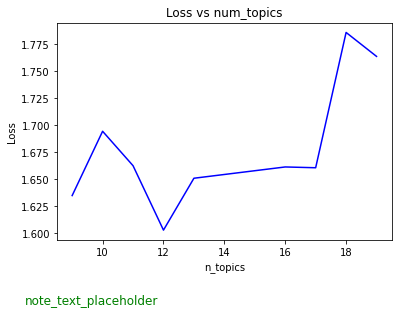

In [25]:
# Show the loss vs. number of topics of Stage 2 optimization.
f, ax = plt.subplots(1)
trials_stage_2_df = trials_stage_2_df.sort_values(by='n_topics')
xs = trials_stage_2_df['n_topics']
ys = trials_stage_2_df['loss']
plt.plot(xs, ys, linestyle='solid',color='blue')
ax.set_title('Loss vs num_topics')
ax.set_xlabel('n_topics')
ax.set_ylabel('Loss')
f.text(0.05, -0.1, 'note_text_placeholder', fontsize=12, color='green')

Note_text will not be displayed
Probably because position [2, 0] does not exist
index 2 is out of bounds for axis 0 with size 2


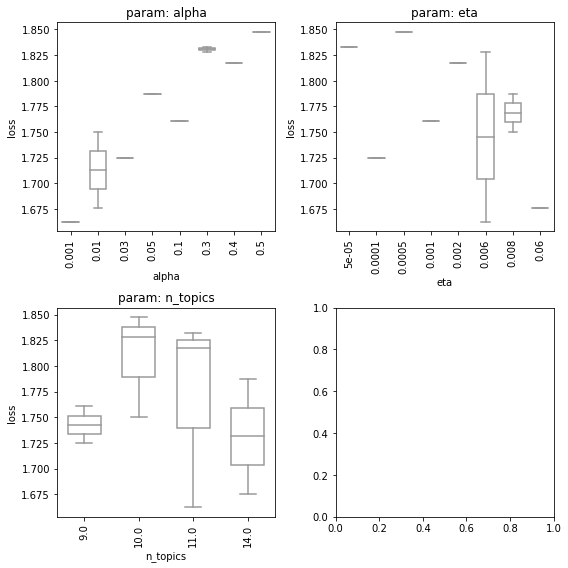

In [31]:
from topic_model_hyper_param_opt import plot_loss_vs_params 

# Plot the loss vs. params of Stage 1 optimization
plot_loss_vs_params(
    trials_stage_1_df,
    quantile_of_loss=1.0,
    ncols_plot=2,
    file_path='test.png',
    note_text='note_text_placeholder',
    save_plot=True,
    show_plot=True
)